In [288]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import kurtosis

# Read, Convert

In [289]:
src_folder_path = "/Users/hugosilva/Documents/Mestrado/2122/Ambient Intelligence/TP/dataset"
df = pd.concat([
    #pd.read_csv(src_folder_path + "/20190720-d447df0770d4add23ae5df25a7d43691.csv", sep=";"),
    pd.read_csv(src_folder_path + "/20220421-a5ad2ede1017aadb3dd3df128cd0b0b5.csv", sep=";"),
    pd.read_csv(src_folder_path + "/20220425-a5ad2ede1017aadb3dd3df128cd0b0b5.csv", sep=";"),
    #pd.read_csv(src_folder_path + "/20220513-d447df0770d4add23ae5df25a7d43691.csv", sep=";")
], ignore_index=True)

In [290]:
arrayFeatures = [
    "acc-x-m/s^2",
    "acc-y-m/s^2",
    "acc-z-m/s^2",
    "gyr-x-rad/s",
    "gyr-y-rad/s",
    "gyr-z-rad/s",
    "ori-angle-x-rad",
    "ori-angle-y-rad",
    "ori-angle-z-rad"
];

def array_from_string(x):
    if isinstance(x, str):
        x = x[1:] # remove first char "["
        x = x[:-1] # remove last char "]"
        return np.fromstring(x, sep=",")
    else:
        return x

# convert arrays
for curFeature in arrayFeatures:
    df[curFeature] = df[curFeature].apply(array_from_string)

In [291]:
STAYING = 10
JUMP_LEFT = 11
JUMP_RIGHT = 12
OTHER = 20
FAKE_JUMP_LEFT = 30
FAKE_JUMP_RIGHT = 31

LABEL_COL = 'activity-code'

def encode_label(value):
    if value == 'staying': return STAYING
    if value == 'jump_left': return JUMP_LEFT
    if value == 'jump_right': return JUMP_RIGHT
    if value == 'other': return OTHER
    if value == 'fake_jump_left': return FAKE_JUMP_LEFT
    if value == 'fake_jump_right': return FAKE_JUMP_RIGHT

# convert label
df[LABEL_COL] = df['activity'].apply(encode_label)

In [292]:
def get_activity_class(activityCode):
    #if activityCode == JUMP_LEFT or activityCode == JUMP_RIGHT:
    #    return 'lateral-move'
    if activityCode == JUMP_LEFT:
        return 'jump_left'
    if activityCode == JUMP_RIGHT:
        return 'jump_right'
    if activityCode == FAKE_JUMP_LEFT or activityCode== FAKE_JUMP_RIGHT:
        return 'fake-move'
    else:
        return 'staying'
    
# convert label
df['activity-class'] = df[LABEL_COL].apply(get_activity_class)

# Explore

In [293]:
print(f'Rows: {df.shape[0]} | Cols: {df.shape[1]}')
df.columns

Rows: 117 | Cols: 63


Index(['startDate', 'endDate', 'acc-accuracy', 'acc-x-m/s^2', 'acc-y-m/s^2',
       'acc-z-m/s^2', 'acc-x-min', 'acc-x-mean', 'acc-x-max', 'acc-x-var',
       'acc-x-std', 'acc-y-min', 'acc-y-mean', 'acc-y-max', 'acc-y-var',
       'acc-y-std', 'acc-z-min', 'acc-z-mean', 'acc-z-max', 'acc-z-var',
       'acc-z-std', 'gyr-accuracy', 'gyr-x-rad/s', 'gyr-y-rad/s',
       'gyr-z-rad/s', 'gyr-x-min', 'gyr-x-mean', 'gyr-x-max', 'gyr-x-var',
       'gyr-x-std', 'gyr-y-min', 'gyr-y-mean', 'gyr-y-max', 'gyr-y-var',
       'gyr-y-std', 'gyr-z-min', 'gyr-z-mean', 'gyr-z-max', 'gyr-z-var',
       'gyr-z-std', 'mag-accuracy', 'ori-angle-x-rad', 'ori-angle-y-rad',
       'ori-angle-z-rad', 'ori-angle-x-min', 'ori-angle-x-mean',
       'ori-angle-x-max', 'ori-angle-x-var', 'ori-angle-x-std',
       'ori-angle-y-min', 'ori-angle-y-mean', 'ori-angle-y-max',
       'ori-angle-y-var', 'ori-angle-y-std', 'ori-angle-z-min',
       'ori-angle-z-mean', 'ori-angle-z-max', 'ori-angle-z-var',
       'ori-angle-

In [294]:
df.head(3)

,startDate,endDate,acc-accuracy,acc-x-m/s^2,acc-y-m/s^2,acc-z-m/s^2,acc-x-min,acc-x-mean,acc-x-max,acc-x-var,...,ori-angle-y-std,ori-angle-z-min,ori-angle-z-mean,ori-angle-z-max,ori-angle-z-var,ori-angle-z-std,activity,device-id,activity-code,activity-class
0,2022-04-20T23:30:22.835Z,2022-04-20T23:30:24.111Z,2,"[0.04962164, 0.04962164, 0.04962164, 0.0496216...","[0.2781539, -0.2528081, -0.2528081, -0.2528081...","[-0.35332966, -0.9656162, -0.9656162, -0.96561...",-3.097097,0.051071,2.626643,1.009453,...,0.100828,0.092167,0.267150,0.538387,0.014938,0.122220,jump_left,a5ad2ede1017aadb3dd3df128cd0b0b5,11,jump_left
1,2022-04-20T23:30:29.997Z,2022-04-20T23:30:31.271Z,2,"[-0.08512929, -0.08512929, -0.08512929, -0.085...","[0.17111015, 0.17111015, 0.17111015, 0.1711101...","[-0.31947136, -0.31947136, -0.31947136, -0.319...",-3.812625,-0.221583,2.575436,1.578221,...,0.122976,0.007846,0.263486,0.916610,0.062400,0.249799,jump_right,a5ad2ede1017aadb3dd3df128cd0b0b5,12,jump_right
2,2022-04-20T23:30:39.887Z,2022-04-20T23:30:40.513Z,2,"[-0.67601275, -1.9999166, -1.4998112, 0.876384...","[-2.5262933, -1.9065523, -1.9065523, -1.406114...","[-3.6014862, -2.072174, -2.5946655, -4.345276,...",-3.812625,-0.189698,2.575436,1.432908,...,0.140555,0.054403,0.261767,0.916610,0.059338,0.243594,staying,a5ad2ede1017aadb3dd3df128cd0b0b5,10,staying


In [295]:
arraySizes = df['acc-x-m/s^2'].apply(lambda array: len(array))
arraySizes = list(set(arraySizes))
print("Raw array sizes: " + str(arraySizes))

Raw array sizes: [64]


In [296]:
def plot_data(dataArray, title):
    pltIndex = 131
    plt.figure(figsize=(14, 2))

    for curPlt in dataArray:
        plt.subplot(pltIndex)
        plt.plot(curPlt['data'])
        plt.ylabel(curPlt['name'])
        plt.grid(True)
        
        pltIndex += 1;

    plt.subplots_adjust(hspace=0.25, wspace=0.35)

    plt.suptitle(title)
    plt.show()

def plot_data_from_row(dataFrame, rowIndex, colNames, colLabel):
    pltData = []
    pltLabel = dataFrame.at[rowIndex, colLabel];
    
    for colName in colNames:
        pltData.append({ 'data': dataFrame.at[rowIndex, colName], 'name': colName })

    plot_data(pltData, pltLabel)

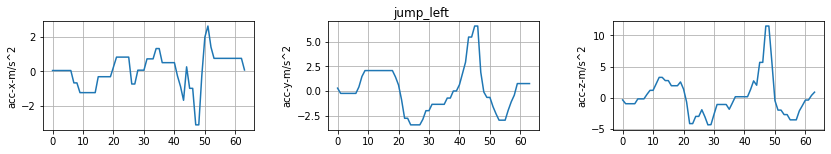

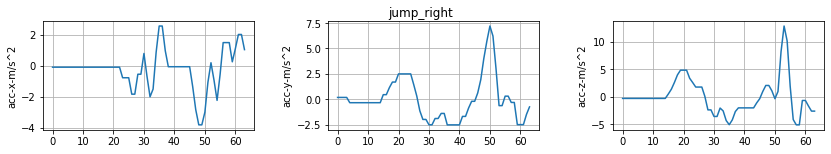

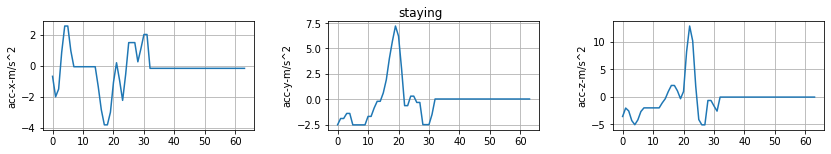

In [297]:
plot_data_from_row(df, 0, ['acc-x-m/s^2', 'acc-y-m/s^2', 'acc-z-m/s^2'], 'activity')
plot_data_from_row(df, 1, ['acc-x-m/s^2', 'acc-y-m/s^2', 'acc-z-m/s^2'], 'activity')
plot_data_from_row(df, 2, ['acc-x-m/s^2', 'acc-y-m/s^2', 'acc-z-m/s^2'], 'activity')

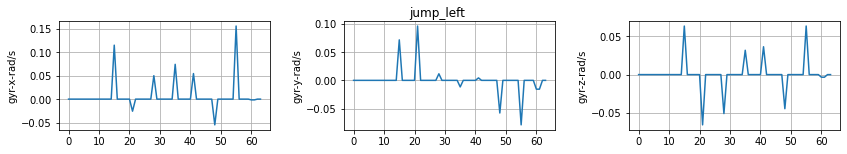

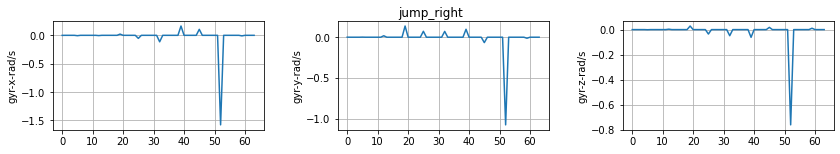

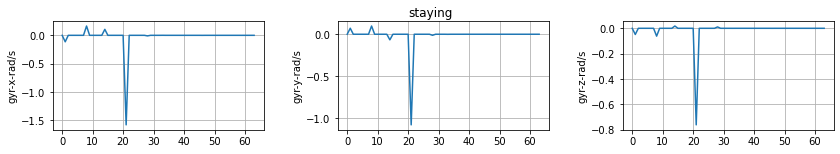

In [298]:
plot_data_from_row(df, 0, ['gyr-x-rad/s', 'gyr-y-rad/s', 'gyr-z-rad/s'], 'activity')
plot_data_from_row(df, 1, ['gyr-x-rad/s', 'gyr-y-rad/s', 'gyr-z-rad/s'], 'activity')
plot_data_from_row(df, 2, ['gyr-x-rad/s', 'gyr-y-rad/s', 'gyr-z-rad/s'], 'activity')

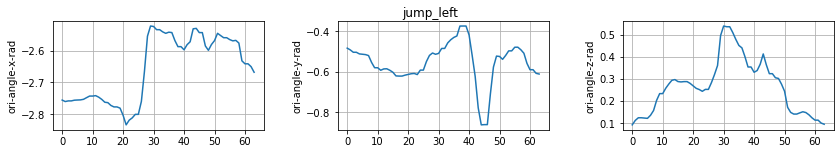

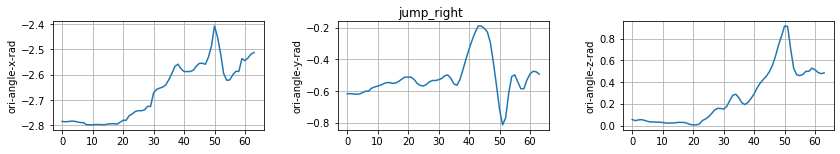

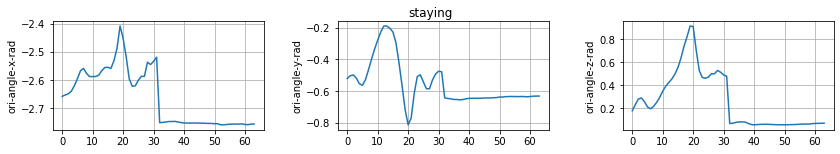

In [299]:
plot_data_from_row(df, 0, ['ori-angle-x-rad', 'ori-angle-y-rad', 'ori-angle-z-rad'], 'activity')
plot_data_from_row(df, 1, ['ori-angle-x-rad', 'ori-angle-y-rad', 'ori-angle-z-rad'], 'activity')
plot_data_from_row(df, 2, ['ori-angle-x-rad', 'ori-angle-y-rad', 'ori-angle-z-rad'], 'activity')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


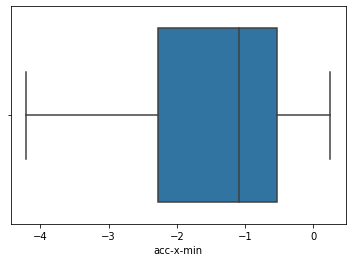

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


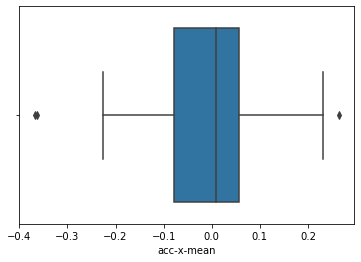

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


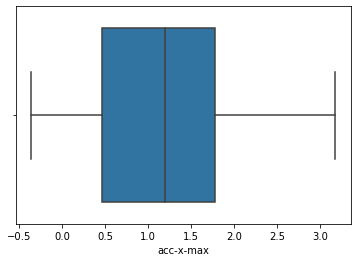

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


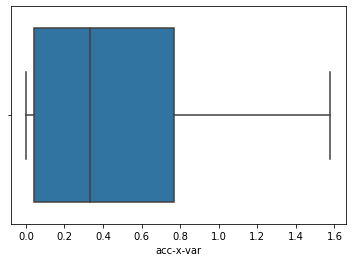

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


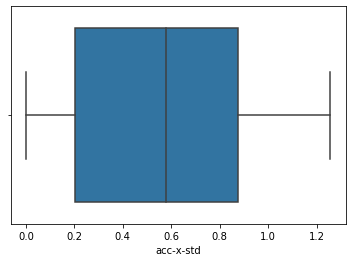

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


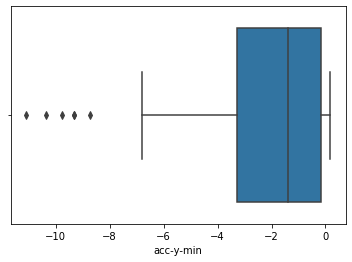

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


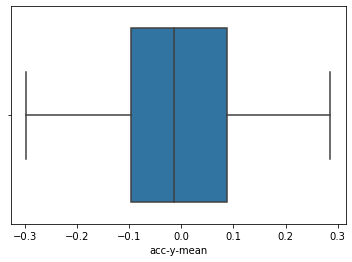

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


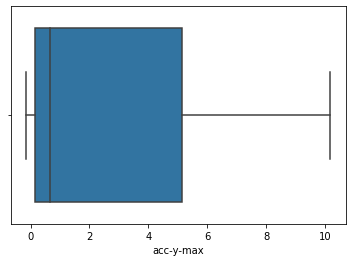

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


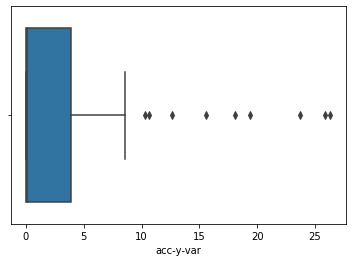

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


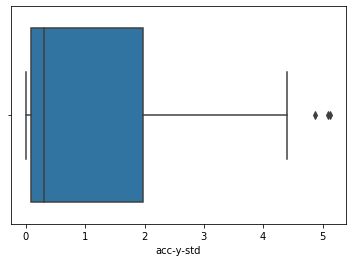

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


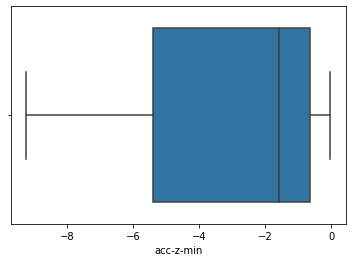

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


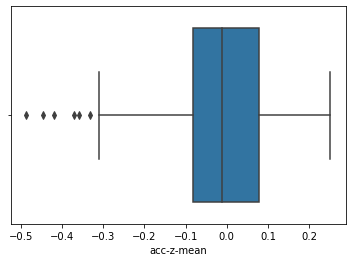

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


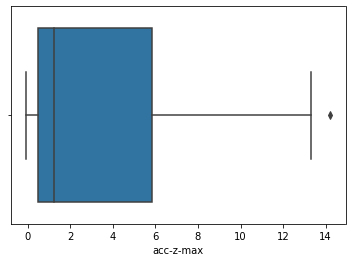

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


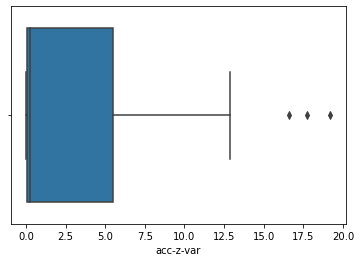

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


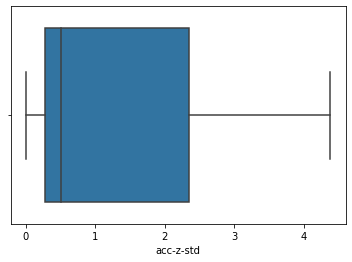

In [300]:
df_for_bp_acc = df[
    [
        'acc-x-min', 'acc-x-mean', 'acc-x-max', 'acc-x-var', 'acc-x-std',
        'acc-y-min', 'acc-y-mean', 'acc-y-max', 'acc-y-var', 'acc-y-std',
        'acc-z-min', 'acc-z-mean', 'acc-z-max', 'acc-z-var', 'acc-z-std',
    ]
].copy()

for column in df_for_bp_acc.columns:
    sn.boxplot(df_for_bp_acc[column])
    plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


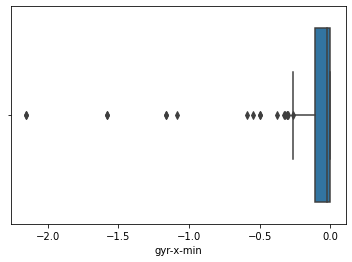

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


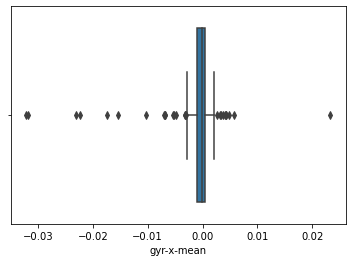

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


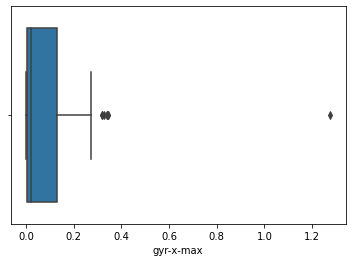

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


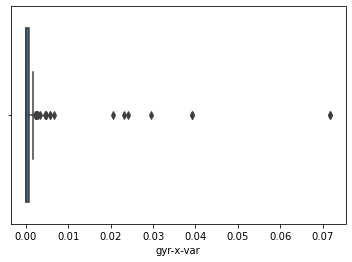

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


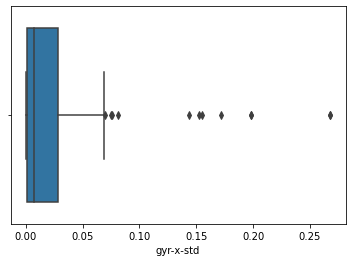

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


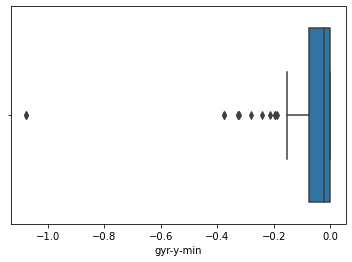

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


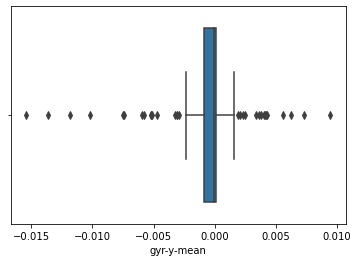

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


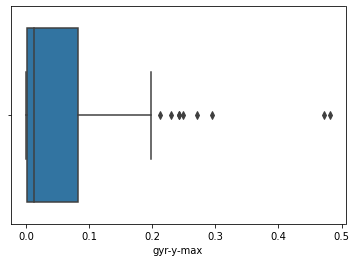

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


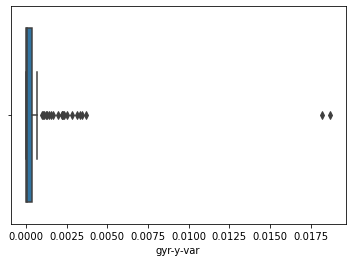

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


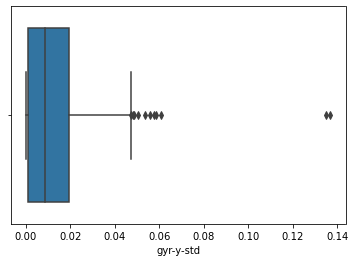

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


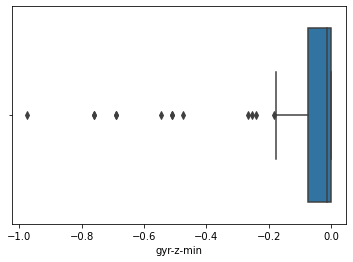

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


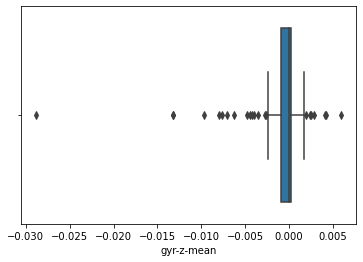

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


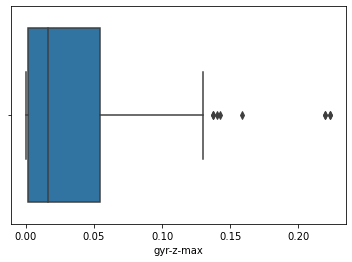

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


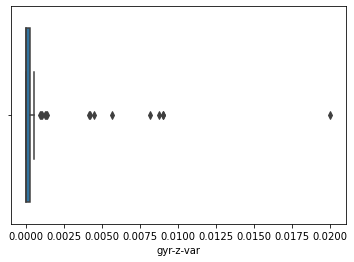

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


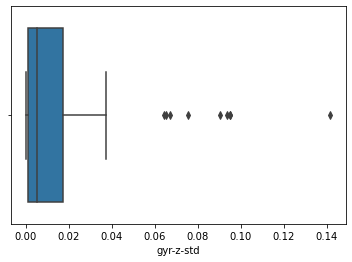

In [301]:
df_for_bp_gyr = df[
    [
        'gyr-x-min', 'gyr-x-mean', 'gyr-x-max', 'gyr-x-var', 'gyr-x-std',
        'gyr-y-min', 'gyr-y-mean', 'gyr-y-max', 'gyr-y-var', 'gyr-y-std',
        'gyr-z-min', 'gyr-z-mean', 'gyr-z-max', 'gyr-z-var', 'gyr-z-std',
    ]
].copy()

for column in df_for_bp_gyr.columns:
    sn.boxplot(df_for_bp_gyr[column])
    plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


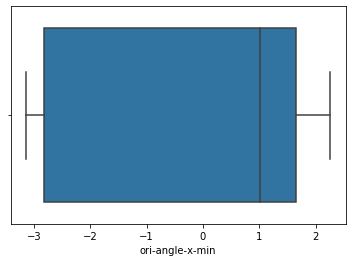

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


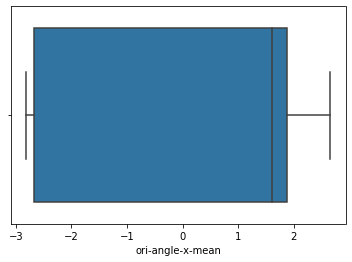

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


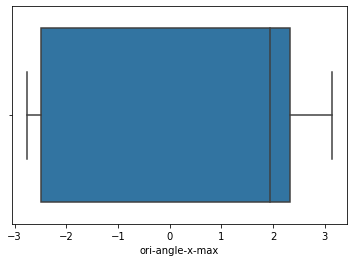

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


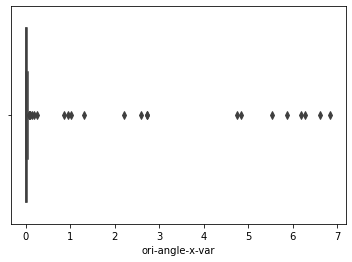

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


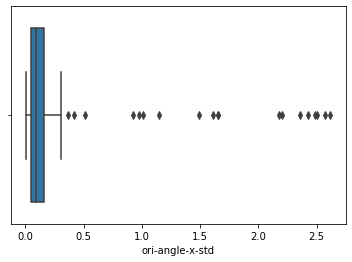

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


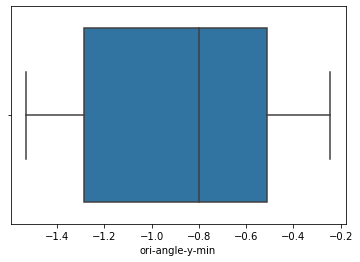

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


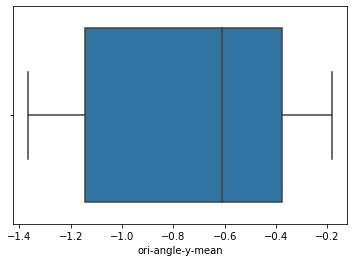

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


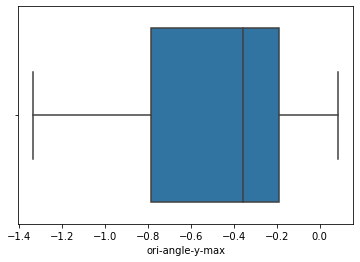

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


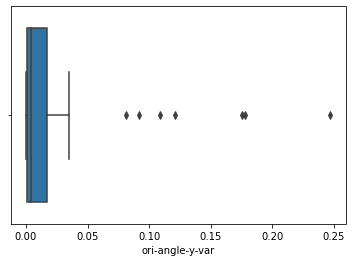

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


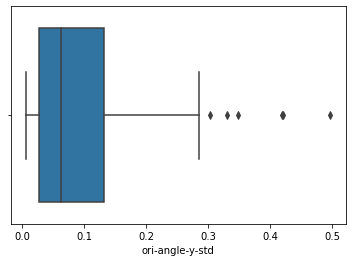

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


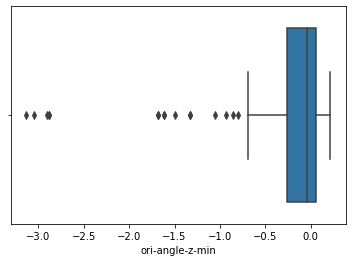

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


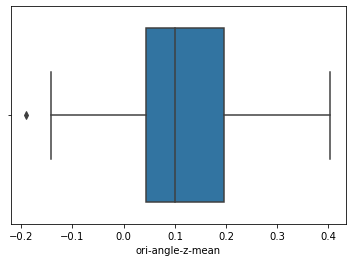

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


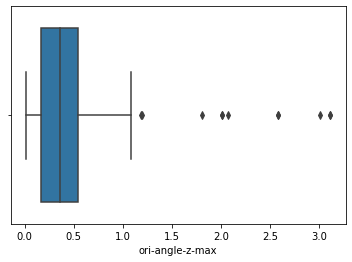

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


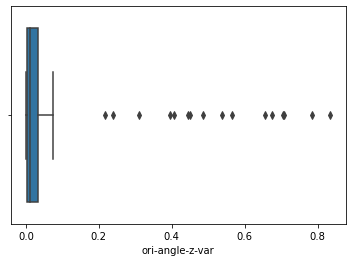

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


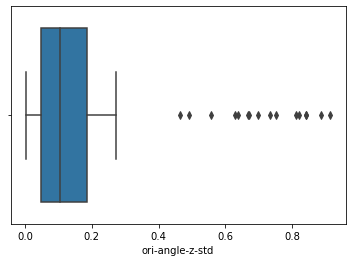

In [302]:
df_for_bp_ori_angle = df[
    [
        'ori-angle-x-min', 'ori-angle-x-mean', 'ori-angle-x-max', 'ori-angle-x-var', 'ori-angle-x-std',
        'ori-angle-y-min', 'ori-angle-y-mean', 'ori-angle-y-max', 'ori-angle-y-var', 'ori-angle-y-std',
        'ori-angle-z-min', 'ori-angle-z-mean', 'ori-angle-z-max', 'ori-angle-z-var', 'ori-angle-z-std',
    ]
].copy()

for column in df_for_bp_ori_angle.columns:
    sn.boxplot(df_for_bp_ori_angle[column])
    plt.show()

# Clean

In [303]:
# remove date cols
df.drop('startDate', inplace=True, axis=1)
df.drop('endDate', inplace=True, axis=1)

# remove sensor accuracy cols
df.drop('acc-accuracy', inplace=True, axis=1)
df.drop('gyr-accuracy', inplace=True, axis=1)
df.drop('mag-accuracy', inplace=True, axis=1)

# remove device-id col
df.drop('device-id', inplace=True, axis=1)

# Enrichment

In [304]:
# signal vector magnitude = sqrt(x^2 + y^2 + z^2)
def svmag(xArray, yArray, zArray):
    svmag_array = np.square([xArray, yArray, zArray])
    svmag_array = np.sum(svmag_array, axis=0)
    svmag_array = np.sqrt(svmag_array)
    return svmag_array

# signal magnitude area = sum(abs(x) + abs(y) + abs(z)) / arraySize
def sma(xArray, yArray, zArray):
    arraySize = len(xArray)
    result = np.abs([xArray, yArray, zArray])
    result = np.sum(result)
    return result / arraySize

# pearson correlation coefficient = cov(A, B) / (std(A) * std(B))
def pcorr(arrayA, arrayB):
    corr_matrix = np.corrcoef(arrayA, arrayB)
    corr = corr_matrix[0][1]
    
    if np.isnan(corr):
        return 0
    else:
        return corr
    
# difference between max and min positions
def min_max_diff(array):
    maxIndex = np.argmax(array, axis=0)
    minIndex = np.argmin(array, axis=0)
    return maxIndex - minIndex

# amplitude range = max - min
def amprange(array):
    return np.max(array) - np.min(array)

# average of array quarter
def mean_of_quarter(array, fromIndex, toIndex):
    array = array[fromIndex:toIndex]
    return np.mean(array)

# average peak-trough distance
def aptd(array):
    peakValue = array[0]
    troughValue = array[0]
    prevSlope = 0
    curSlope = 0
    sum = 0
    arraySize = len(array)
    evaluateSize = arraySize + 1
    
    for i in range(evaluateSize):
        if i == 0:
            curValue = array[i]
            continue
        
        prevValue = curValue
        prevSlope = curSlope
        
        if i < arraySize:
            curValue = array[i]
            curSlope = curValue - prevValue
        else:
            curSlope = prevSlope * -1
        
        # peak found
        if prevSlope > 0 and curSlope <= 0:
            peakValue = prevValue
            sum += peakValue - troughValue
            #print(f'=== peak found ({troughValue} to {peakValue})')
        # trough found
        elif prevSlope < 0 and curSlope >= 0:
            troughValue = prevValue
            sum += troughValue - peakValue
            #print(f'=== trough found ({peakValue} to {troughValue})')
            
    return sum / arraySize

def median_absolute_deviation(array):
    return np.median(np.absolute(array - np.median(array)))

def fft(array):
    #print(array)
    dft1 = np.fft.fft(array)

    dft1_real = np.real( dft1 )
    #print(dft1_real)
    dft1_imag = np.imag( dft1 )
    #print(dft1_imag)

    magFft = []

    for i in range(len(dft1_real)):
        magFft.append(np.sqrt(np.square(dft1_real[i]) + np.square(dft1_imag[i])))
    
    return magFft

def energy(magFftArray):
    energy = 0
    
    for i in range(len(magFftArray)):
        energy = energy + np.square(magFftArray[i])
    
    if len(magFftArray) > 0:
        energy = energy / len(magFftArray)
    
    return energy

def entropy(magFftArray):
    entropy = 0
    psd = []
    
    if len(magFftArray) > 0:
        for i in range(len(magFftArray)):
            psd.append(np.square(magFftArray[i]) / len(magFftArray))
    
        psdSum = np.sum(psd)
        
        if psdSum > 0:
            for i in range(len(magFftArray)):
                psd[i] = psd[i] / psdSum
                
            for i in range(len(magFftArray)):
                if psd[i] != 0:
                    entropy = entropy + (psd[i] * np.log(psd[i]))
    
            entropy = entropy * -1
    
    return entropy

def calc_kurtosis(array):
    return kurtosis(array, fisher=False)

def medfilt (array, k):
    """Apply a length-k median filter to a 1D array x.
    Boundaries are extended by repeating endpoints.
    """
    assert k % 2 == 1, "Median filter length must be odd."
    assert array.ndim == 1, "Input must be one-dimensional."
    k2 = (k - 1) // 2
    y = np.zeros ((len (array), k), dtype=array.dtype)
    y[:,k2] = array
    
    for i in range (k2):
        j = k2 - i
        y[j:,i] = array[:-j]
        y[:j,i] = array[0]
        y[:-j,-(i+1)] = array[j:]
        y[-j:,-(i+1)] = array[-1]
        
    return np.median (y, axis=1)

def meanfilt (array, k):
    """Apply a length-k mean filter to a 1D array x.
    Boundaries are extended by repeating endpoints.
    """

    assert k % 2 == 1, "Mean filter length must be odd."
    assert array.ndim == 1, "Input must be one-dimensional."
    
    k2 = (k - 1) // 2
    y = np.zeros ((len (array), k), dtype=array.dtype)
    y[:,k2] = array
    for i in range (k2):
        j = k2 - i
        y[j:,i] = array[:-j]
        y[:j,i] = array[0]
        y[:-j,-(i+1)] = array[j:]
        y[-j:,-(i+1)] = array[-1]
    return np.mean (y, axis=1)

[ 0.04962164  0.04962164  0.04962164  0.04962164  0.04962164  0.04962164
  0.04962164 -0.66660583 -0.66660583 -1.231      -1.231      -1.231
 -1.231      -1.231      -1.231      -0.3093114  -0.3093114  -0.3093114
 -0.3093114  -0.3093114   0.25718713  0.8262453   0.8262453   0.8262453
  0.8262453   0.8262453  -0.73108625 -0.73108625  0.06886268  0.06886268
  0.06886268  0.72461414  0.72461414  0.72461414  1.3221442   1.3221442
  0.5049319   0.5049319   0.5049319   0.5049319   0.5049319  -0.26393008
 -0.87225246 -1.6742179   0.2634883  -0.9819827  -0.9819827  -3.0970974
 -3.0970974  -0.22487688  1.988946    2.6266427   1.4049553   0.75398123
  0.75398123  0.75398123  0.75398123  0.75398123  0.75398123  0.75398123
  0.75398123  0.75398123  0.75398123  0.0809626 ]


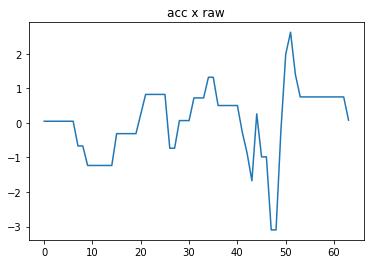

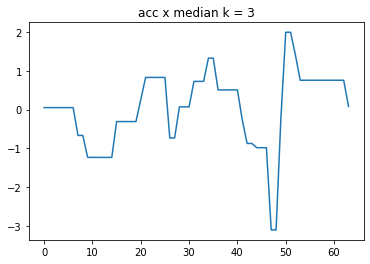

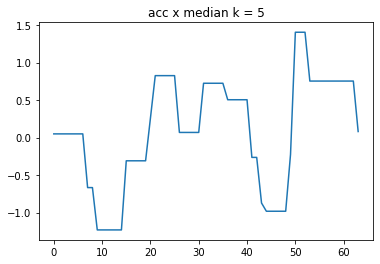

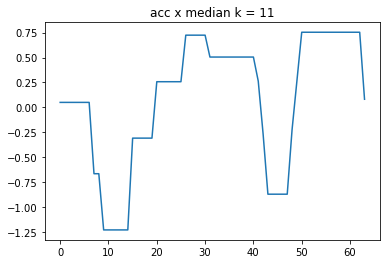

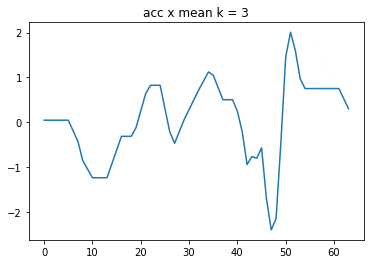

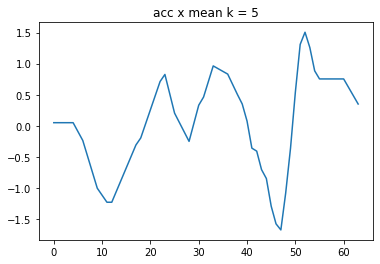

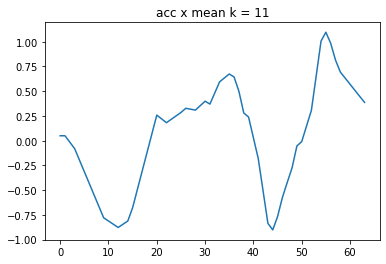

In [305]:
print(df.at[0, 'acc-x-m/s^2'])
#print(fft(df.at[0, 'acc-x-m/s^2']))
#print(energy(fft(df.at[0, 'acc-x-m/s^2'])))
#print(entropy(fft(df.at[0, 'acc-x-m/s^2'])))
#print(calc_kurtosis(df.at[0, 'acc-x-m/s^2']))
#print(medfilt(df.at[0, 'acc-x-m/s^2'], 3))
#print(medfilt(df.at[0, 'acc-x-m/s^2'], 5))

plt.plot(df.at[0, 'acc-x-m/s^2'])
plt.title('acc x raw')
plt.show()

plt.plot(medfilt(df.at[0, 'acc-x-m/s^2'], 3))
plt.title('acc x median k = 3')
plt.show()
plt.plot(medfilt(df.at[0, 'acc-x-m/s^2'], 5))
plt.title('acc x median k = 5')
plt.show()
plt.plot(medfilt(df.at[0, 'acc-x-m/s^2'], 11))
plt.title('acc x median k = 11')
plt.show()

plt.plot(meanfilt(df.at[0, 'acc-x-m/s^2'], 3))
plt.title('acc x mean k = 3')
plt.show()
plt.plot(meanfilt(df.at[0, 'acc-x-m/s^2'], 5))
plt.title('acc x mean k = 5')
plt.show()
plt.plot(meanfilt(df.at[0, 'acc-x-m/s^2'], 11))
plt.title('acc x mean k = 11')
plt.show()

In [306]:
newFeatures = [
    # accelerometer
    {
        'name': 'acc-svmag', 'dtype': object,
        'func': (lambda row: svmag(row["acc-x-m/s^2"], row["acc-y-m/s^2"], row["acc-z-m/s^2"]))
    },
    { 
        'name': 'acc-sma', 'dtype': np.float64,
        'func': (lambda row: sma(row["acc-x-m/s^2"], row["acc-y-m/s^2"], row["acc-z-m/s^2"]))
    },
    { 
        'name': 'acc-pcorr-xy', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["acc-x-m/s^2"], row["acc-y-m/s^2"]))
    },
    { 
        'name': 'acc-pcorr-xz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["acc-x-m/s^2"], row["acc-z-m/s^2"]))
    },
    { 
        'name': 'acc-pcorr-yz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["acc-y-m/s^2"], row["acc-z-m/s^2"]))
    },
    {
        'name': 'acc-x-min-max-diff', 'dtype': np.float64,
        'func': (lambda row: min_max_diff(row["acc-x-m/s^2"]))
    },
    {
        'name': 'acc-x-amprange', 'dtype': np.float64,
        'func': (lambda row: amprange(row["acc-x-m/s^2"]))
    },
    {
        'name': 'acc-x-mean-1quarter', 'dtype': np.float64,
        'func': (lambda row: mean_of_quarter(row["acc-x-m/s^2"], 0, 16))
    },
    {
        'name': 'acc-x-mean-2quarter', 'dtype': np.float64,
        'func': (lambda row: mean_of_quarter(row["acc-x-m/s^2"], 16, 32))
    },
    {
        'name': 'acc-x-mean-3quarter', 'dtype': np.float64,
        'func': (lambda row: mean_of_quarter(row["acc-x-m/s^2"], 32, 48))
    },
    {
        'name': 'acc-x-mean-4quarter', 'dtype': np.float64,
        'func': (lambda row: mean_of_quarter(row["acc-x-m/s^2"], 32, 64))
    },
    {
        'name': 'acc-x-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["acc-x-m/s^2"]))
    },
    {
        'name': 'acc-y-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["acc-y-m/s^2"]))
    },
    {
        'name': 'acc-z-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["acc-z-m/s^2"]))
    },
    {
        'name': 'acc-x-mad', 'dtype': np.float64,
        'func': (lambda row: median_absolute_deviation(row["acc-x-m/s^2"]))
    },
    {
        'name': 'acc-y-mad', 'dtype': np.float64,
        'func': (lambda row: median_absolute_deviation(row["acc-y-m/s^2"]))
    },
    {
        'name': 'acc-z-mad', 'dtype': np.float64,
        'func': (lambda row: median_absolute_deviation(row["acc-z-m/s^2"]))
    },
    {
        'name': 'acc-x-fft', 'dtype': object,
        'func': (lambda row: fft(row["acc-x-m/s^2"]))
    },
    {
        'name': 'acc-y-fft', 'dtype': object,
        'func': (lambda row: fft(row["acc-y-m/s^2"]))
    },
    {
        'name': 'acc-z-fft', 'dtype': object,
        'func': (lambda row: fft(row["acc-z-m/s^2"]))
    },
    {
        'name': 'acc-x-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["acc-x-fft"]))
    },
    {
        'name': 'acc-y-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["acc-y-fft"]))
    },
    {
        'name': 'acc-z-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["acc-z-fft"]))
    },
    {
        'name': 'acc-x-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["acc-x-fft"]))
    },
    {
        'name': 'acc-y-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["acc-y-fft"]))
    },
    {
        'name': 'acc-z-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["acc-z-fft"]))
    },
    {
        'name': 'acc-x-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["acc-x-m/s^2"]))
    },
    {
        'name': 'acc-y-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["acc-y-m/s^2"]))
    },
    {
        'name': 'acc-z-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["acc-z-m/s^2"]))
    },
    # gyroscope
    {
        'name': 'gyr-svmag', 'dtype': object,
        'func': (lambda row: svmag(row["gyr-x-rad/s"], row["gyr-y-rad/s"], row["gyr-z-rad/s"]))
    },
    { 
        'name': 'gyr-sma', 'dtype': np.float64,
        'func': (lambda row: sma(row["gyr-x-rad/s"], row["gyr-y-rad/s"], row["gyr-z-rad/s"]))
    },
    { 
        'name': 'gyr-pcorr-xy', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["gyr-x-rad/s"], row["gyr-y-rad/s"]))
    },
    { 
        'name': 'gyr-pcorr-xz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["gyr-x-rad/s"], row["gyr-z-rad/s"]))
    },
    { 
        'name': 'gyr-pcorr-yz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["gyr-y-rad/s"], row["gyr-z-rad/s"]))
    },
    {
        'name': 'gyr-x-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["gyr-x-rad/s"]))
    },
    {
        'name': 'gyr-y-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["gyr-y-rad/s"]))
    },
    {
        'name': 'gyr-z-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["gyr-z-rad/s"]))
    },
    {
        'name': 'gyr-x-mad', 'dtype': np.float64,
        'func': (lambda row: median_absolute_deviation(row["gyr-x-rad/s"]))
    },
    {
        'name': 'gyr-y-mad', 'dtype': np.float64,
        'func': (lambda row: median_absolute_deviation(row["gyr-y-rad/s"]))
    },
    {
        'name': 'gyr-z-mad', 'dtype': np.float64,
        'func': (lambda row: median_absolute_deviation(row["gyr-z-rad/s"]))
    },
    {
        'name': 'gyr-x-fft', 'dtype': object,
        'func': (lambda row: fft(row["gyr-x-rad/s"]))
    },
    {
        'name': 'gyr-y-fft', 'dtype': object,
        'func': (lambda row: fft(row["gyr-y-rad/s"]))
    },
    {
        'name': 'gyr-z-fft', 'dtype': object,
        'func': (lambda row: fft(row["gyr-z-rad/s"]))
    },
    {
        'name': 'gyr-x-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["gyr-x-fft"]))
    },
    {
        'name': 'gyr-y-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["gyr-y-fft"]))
    },
    {
        'name': 'gyr-z-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["gyr-z-fft"]))
    },
    {
        'name': 'gyr-x-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["gyr-x-fft"]))
    },
    {
        'name': 'gyr-y-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["gyr-y-fft"]))
    },
    {
        'name': 'gyr-z-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["gyr-z-fft"]))
    },
    {
        'name': 'gyr-x-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["gyr-x-rad/s"]))
    },
    {
        'name': 'gyr-y-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["gyr-y-rad/s"]))
    },
    {
        'name': 'gyr-z-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["gyr-z-rad/s"]))
    },
    # magnetometer
    {
        'name': 'mag-svmag', 'dtype': object,
        'func': (lambda row: svmag(row["ori-angle-x-rad"], row["ori-angle-y-rad"], row["ori-angle-z-rad"]))
    },
    { 
        'name': 'mag-sma', 'dtype': np.float64,
        'func': (lambda row: sma(row["ori-angle-x-rad"], row["ori-angle-y-rad"], row["ori-angle-z-rad"]))
    },
    { 
        'name': 'mag-pcorr-xy', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["ori-angle-x-rad"], row["ori-angle-y-rad"]))
    },
    { 
        'name': 'mag-pcorr-xz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["ori-angle-x-rad"], row["ori-angle-z-rad"]))
    },
    { 
        'name': 'mag-pcorr-yz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["ori-angle-y-rad"], row["ori-angle-z-rad"]))
    },
    {
        'name': 'mag-x-fft', 'dtype': object,
        'func': (lambda row: fft(row["ori-angle-x-rad"]))
    },
    {
        'name': 'mag-y-fft', 'dtype': object,
        'func': (lambda row: fft(row["ori-angle-y-rad"]))
    },
    {
        'name': 'mag-z-fft', 'dtype': object,
        'func': (lambda row: fft(row["ori-angle-z-rad"]))
    },
    {
        'name': 'mag-x-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["mag-x-fft"]))
    },
    {
        'name': 'mag-y-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["mag-y-fft"]))
    },
    {
        'name': 'mag-z-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["mag-z-fft"]))
    },
    {
        'name': 'mag-x-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["mag-x-fft"]))
    },
    {
        'name': 'mag-y-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["mag-y-fft"]))
    },
    {
        'name': 'mag-z-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["mag-z-fft"]))
    },
    {
        'name': 'mag-x-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["ori-angle-x-rad"]))
    },
    {
        'name': 'mag-y-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["ori-angle-y-rad"]))
    },
    {
        'name': 'mag-z-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["ori-angle-z-rad"]))
    },
    # activity label
    {
        'name': 'lateral-move', 'dtype': np.bool,
        'func': (lambda row: row[LABEL_COL] == JUMP_LEFT or row[LABEL_COL] == JUMP_RIGHT)
    },
    {
        'name': 'fake-move', 'dtype': np.bool,
        'func': (lambda row: row[LABEL_COL] == FAKE_JUMP_LEFT or row[LABEL_COL] == FAKE_JUMP_RIGHT)
    },
    {
        'name': 'jump-left', 'dtype': np.bool,
        'func': (lambda row: row[LABEL_COL] == JUMP_LEFT)
    },
    {
        'name': 'jump-right', 'dtype': np.bool,
        'func': (lambda row: row[LABEL_COL] == JUMP_RIGHT)
    },
    {
        'name': 'staying', 'dtype': np.bool,
        'func': (lambda row: row[LABEL_COL] != JUMP_LEFT and row[LABEL_COL] != JUMP_RIGHT)
    }
    
    #TODO: add the folllowing
    # normalized energy
    
    #Maximum Peaks:
    #• Mean
    #• Median
    #• Standard Deviation
    #• Variance
    #• Five Largest Distances of Maximum Peaks
]

print("added new features")

# add new features
for newFeature in newFeatures:
    # add new column
    df[newFeature['name']] = pd.Series(df[LABEL_COL].apply(lambda x: 0), dtype=newFeature['dtype'])

    # fill new column
    for rowIndex, row in df.iterrows():
        df.at[rowIndex, newFeature['name']] = newFeature['func'](row);
        
        if (rowIndex == 0):
            print(newFeature['name'] + ": " + str(df.at[rowIndex, newFeature['name']]))

added new features
acc-svmag: [ 0.45240883  0.99939426  0.99939426  0.99939426  0.99939426  0.31950775
  0.31950775  0.80102453  1.69392604  2.67384755  2.67384755  3.26337035
  4.04976048  4.04976048  3.64853477  3.44849511  2.83372395  2.83372395
  2.83372395  2.91517894  1.53021918  1.3971815   5.06688668  5.06688668
  4.63949967  4.63949967  4.01324607  4.65479463  5.22124277  4.76940971
  3.33726441  1.88680668  1.88680668  1.88680668  2.18701602  2.65591135
  1.24091182  0.89912205  0.52858967  0.52858967  0.81745668  1.78381716
  3.31109086  6.31031135  5.81543856  8.73673688  8.73673688 12.07002408
 11.92231991  5.72584734  2.14570398  3.65742497  3.36240132  4.08813318
  4.08813318  4.69115998  4.13276902  3.79956856  2.29000531  1.65000346
  1.12050632  1.12050632  1.11875138  1.1612659 ]
acc-sma: 4.7844445618750004
acc-pcorr-xy: -0.5233921900079217
acc-pcorr-xz: -0.7416859885092927
acc-pcorr-yz: 0.6804506145293179
acc-x-min-max-diff: 4.0
acc-x-amprange: 5.7237401000000006
ac

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


acc-x-mean-4quarter: 0.291548308125
acc-x-aptd: -0.022545208749999997
acc-y-aptd: 0.108696806953125
acc-z-aptd: -0.2194088065625
acc-x-mad: 0.68511855
acc-y-mad: 1.69103005
acc-z-mad: 1.6534860500000002
acc-x-fft: [3.26857199, 8.196225661273013, 24.71441893118526, 10.806937413222522, 20.12344899801002, 3.818598624718434, 6.936738703913267, 14.113526963668006, 5.164509595360006, 9.827552417549725, 7.123516544650968, 10.632394270736746, 10.196110035166393, 9.100911928097624, 2.2544159452420223, 4.7940091264161, 1.6805849166352804, 2.9365935664677663, 1.581917425895213, 2.493903161293074, 3.8716230910339204, 2.774997814342363, 1.2447486766457825, 0.42002276716027565, 1.8126276815566196, 2.8781606116248435, 2.1514814801872726, 3.7305538922237154, 2.4952703146281427, 2.682976942746835, 2.937887603738904, 2.307330523038181, 1.8796120099999998, 2.30733052303818, 2.9378876037389037, 2.682976942746835, 2.4952703146281427, 3.7305538922237154, 2.151481480187272, 2.878160611624843, 1.8126276815566

gyr-x-kurtosis: 17.781305136094417
gyr-y-kurtosis: 16.943439694512684
gyr-z-kurtosis: 11.063557103014135
mag-svmag: [2.79948993 2.80633647 2.8069318  2.8069318  2.80613156 2.80583457
 2.80640309 2.80662447 2.81095104 2.81367487 2.81367487 2.81712596
 2.82223319 2.83059568 2.84123047 2.84364572 2.85594293 2.86073747
 2.86073747 2.86270932 2.88294199 2.91048379 2.89526874 2.88872021
 2.87401567 2.87401567 2.82845212 2.73468807 2.62882385 2.62118592
 2.63019815 2.63459108 2.63459108 2.63109397 2.62711666 2.61687112
 2.61499798 2.62575681 2.63787918 2.63787918 2.65119179 2.65403427
 2.67144622 2.67991846 2.69745195 2.70442192 2.70442192 2.69806688
 2.6791877  2.64735003 2.63261218 2.60720522 2.60880384 2.61062496
 2.61062496 2.61343361 2.61757497 2.61825779 2.62932716 2.69359439
 2.70893767 2.70893767 2.72104753 2.73899758]
mag-sma: 3.478760708375
mag-pcorr-xy: 0.13280839282386117
mag-pcorr-xz: 0.4273373108126142
mag-pcorr-yz: 0.04110647700908269
mag-x-fft: [169.9916263, 4.0962547331012535

# Describe

In [307]:
df.describe()

,acc-x-min,acc-x-mean,acc-x-max,acc-x-var,acc-x-std,acc-y-min,acc-y-mean,acc-y-max,acc-y-var,acc-y-std,...,mag-pcorr-yz,mag-x-energy,mag-y-energy,mag-z-energy,mag-x-entropy,mag-y-entropy,mag-z-entropy,mag-x-kurtosis,mag-y-kurtosis,mag-z-kurtosis
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,...,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,-1.394628,-0.009685,1.232767,0.438645,0.552228,-2.025209,-0.005802,2.589721,2.711957,1.057972,...,0.013564,338.771413,43.385551,6.916730,0.289069,0.193207,1.421880,8.448418,9.565314,8.052750
std,1.110317,0.115487,0.887533,0.425449,0.367208,2.487479,0.127514,2.987690,5.174448,1.267432,...,0.511778,122.545978,39.321856,12.566034,0.667283,0.224546,0.899887,15.057164,15.220196,14.560129
min,-4.213076,-0.368517,-0.364124,0.000000,0.000000,-11.105948,-0.298359,-0.158317,0.000000,0.000000,...,-0.954200,130.022021,2.138823,0.005755,0.000034,0.000302,0.013567,1.025198,1.004287,1.042887
25%,-2.280317,-0.079438,0.463732,0.040476,0.201188,-3.263678,-0.095789,0.144992,0.007904,0.088906,...,-0.354710,219.152658,9.383628,0.723644,0.005187,0.012747,0.793479,2.026849,2.353687,2.087421
50%,-1.095220,0.008566,1.199074,0.332481,0.576612,-1.400006,-0.013505,0.674297,0.088978,0.298293,...,-0.046303,337.272248,24.622376,2.442720,0.015052,0.100930,1.324807,2.794384,3.717052,2.629274
75%,-0.527206,0.056661,1.772435,0.766886,0.875720,-0.158317,0.087845,5.156753,3.866284,1.966287,...,0.369148,461.489991,89.198216,5.074076,0.066958,0.353563,2.114316,4.719968,5.233110,4.000924
max,0.246406,0.264318,3.178488,1.578221,1.256273,0.179110,0.285827,10.179729,26.315008,5.129816,...,0.979660,509.009661,119.785534,56.239648,2.709630,1.029684,3.722936,60.749162,60.191539,61.327190


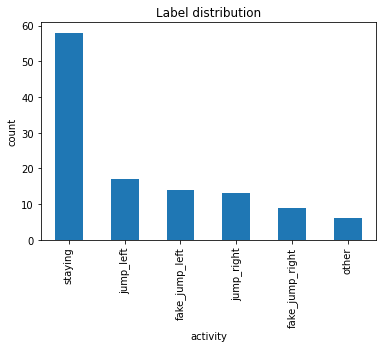

In [308]:
df['activity'].value_counts().plot.bar(title='Label distribution')
plt.ylabel('count')
plt.xlabel('activity')
plt.show()

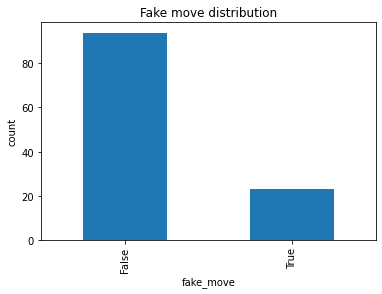

In [309]:
df['fake-move'].value_counts().plot.bar(title='Fake move distribution')
plt.ylabel('count')
plt.xlabel('fake_move')
plt.show()

In [310]:
MIN_NEG_CORR = -0.3
MIN_POS_CORR = 0.3

In [311]:
scaled_df = df.copy()

def drop_array_features(dataframe):
    # remove original array features
    for curFeature in arrayFeatures:
        dataframe.drop(curFeature, inplace=True, axis=1)

    # remove extracted array features
    dataframe.drop('acc-svmag', inplace=True, axis=1)
    dataframe.drop('gyr-svmag', inplace=True, axis=1)
    dataframe.drop('mag-svmag', inplace=True, axis=1)
    dataframe.drop('acc-x-fft', inplace=True, axis=1)
    dataframe.drop('acc-y-fft', inplace=True, axis=1)
    dataframe.drop('acc-z-fft', inplace=True, axis=1)
    dataframe.drop('gyr-x-fft', inplace=True, axis=1)
    dataframe.drop('gyr-y-fft', inplace=True, axis=1)
    dataframe.drop('gyr-z-fft', inplace=True, axis=1)
    dataframe.drop('mag-x-fft', inplace=True, axis=1)
    dataframe.drop('mag-y-fft', inplace=True, axis=1)
    dataframe.drop('mag-z-fft', inplace=True, axis=1)
    
drop_array_features(scaled_df)

In [312]:
# apply feature scaling
scaled_df.drop('activity', inplace=True, axis=1)
scaled_df.drop('activity-class', inplace=True, axis=1)

col_names = scaled_df.columns
scaled_df = pd.DataFrame(MinMaxScaler().fit_transform(scaled_df))
scaled_df.columns = col_names

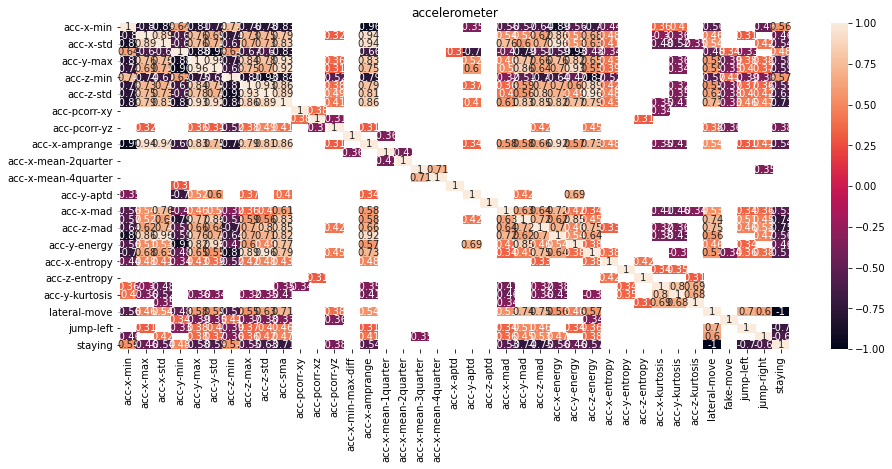

In [313]:
dfCorr = scaled_df[[
    'acc-x-min',
    #'acc-x-mean',
    'acc-x-max',
    #'acc-x-var',
    'acc-x-std',
    'acc-y-min',
    #'acc-y-mean',
    'acc-y-max',
    #'acc-y-var',
    'acc-y-std',
    'acc-z-min',
    #'acc-z-mean',
    'acc-z-max',
    #'acc-z-var',
    'acc-z-std',
    'acc-sma',
    'acc-pcorr-xy',
    'acc-pcorr-xz',
    'acc-pcorr-yz',
    'acc-x-min-max-diff',
    'acc-x-amprange',
    'acc-x-mean-1quarter',
    'acc-x-mean-2quarter',
    'acc-x-mean-3quarter',
    'acc-x-mean-4quarter',
    'acc-x-aptd',
    'acc-y-aptd',
    'acc-z-aptd',
    'acc-x-mad',
    'acc-y-mad',
    'acc-z-mad',
    'acc-x-energy',
    'acc-y-energy',
    'acc-z-energy',
    'acc-x-entropy',
    'acc-y-entropy',
    'acc-z-entropy',
    'acc-x-kurtosis',
    'acc-y-kurtosis',
    'acc-z-kurtosis',
    'lateral-move',
    'fake-move',
    'jump-left',
    'jump-right',
    'staying',
    #LABEL_COL
]].corr()

dfCorr = dfCorr[((dfCorr > MIN_POS_CORR) | (dfCorr < MIN_NEG_CORR))]

plt.figure(figsize=(15,6))
plt.title('accelerometer')
sn.heatmap(dfCorr, annot=True)
plt.show()

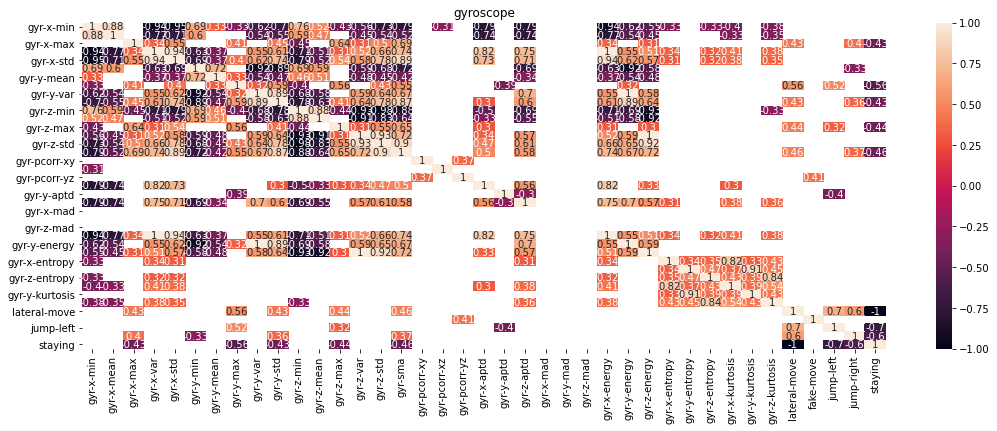

In [314]:
dfCorr = scaled_df[[
    'gyr-x-min',
    'gyr-x-mean',
    'gyr-x-max',
    'gyr-x-var',
    'gyr-x-std',
    'gyr-y-min',
    'gyr-y-mean',
    'gyr-y-max',
    'gyr-y-var',
    'gyr-y-std',
    'gyr-z-min',
    'gyr-z-mean',
    'gyr-z-max',
    'gyr-z-var',
    'gyr-z-std',
    'gyr-sma',
    'gyr-pcorr-xy',
    'gyr-pcorr-xz',
    'gyr-pcorr-yz',
    'gyr-x-aptd',
    'gyr-y-aptd',
    'gyr-z-aptd',
    'gyr-x-mad',
    'gyr-y-mad',
    'gyr-z-mad',
    'gyr-x-energy',
    'gyr-y-energy',
    'gyr-z-energy',
    'gyr-x-entropy',
    'gyr-y-entropy',
    'gyr-z-entropy',
    'gyr-x-kurtosis',
    'gyr-y-kurtosis',
    'gyr-z-kurtosis',
    'lateral-move',
    'fake-move',
    'jump-left',
    'jump-right',
    'staying',
    #LABEL_COL
]].corr()

dfCorr = dfCorr[((dfCorr > MIN_POS_CORR) | (dfCorr < MIN_NEG_CORR))]

plt.figure(figsize=(18,6))
plt.title('gyroscope')
sn.heatmap(dfCorr, annot=True)
plt.show()

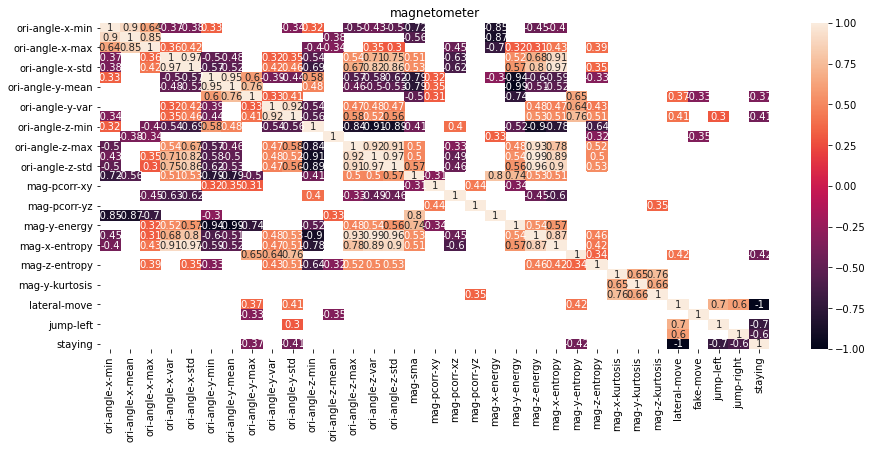

In [315]:
dfCorr = scaled_df[[
    'ori-angle-x-min',
    'ori-angle-x-mean',
    'ori-angle-x-max',
    'ori-angle-x-var',
    'ori-angle-x-std',
    'ori-angle-y-min',
    'ori-angle-y-mean',
    'ori-angle-y-max',
    'ori-angle-y-var',
    'ori-angle-y-std',
    'ori-angle-z-min',
    'ori-angle-z-mean',
    'ori-angle-z-max',
    'ori-angle-z-var',
    'ori-angle-z-std',
    'mag-sma',
    'mag-pcorr-xy',
    'mag-pcorr-xz',
    'mag-pcorr-yz',
    'mag-x-energy',
    'mag-y-energy',
    'mag-z-energy',
    'mag-x-entropy',
    'mag-y-entropy',
    'mag-z-entropy',
    'mag-x-kurtosis',
    'mag-y-kurtosis',
    'mag-z-kurtosis',
    'lateral-move',
    'fake-move',
    'jump-left',
    'jump-right',
    'staying',
    #LABEL_COL
]].corr()

dfCorr = dfCorr[((dfCorr > MIN_POS_CORR) | (dfCorr < MIN_NEG_CORR))]

plt.figure(figsize=(15,6))
plt.title('magnetometer')
sn.heatmap(dfCorr, annot=True)
plt.show()

In [316]:
scaled_df = df.copy()

drop_array_features(scaled_df)

# save to csv
scaled_df.to_csv(src_folder_path + '/dataset.csv', index=False, header=True, sep=",", decimal='.')

#df_lateral_move = df[df['lateral-move'] == True]
#df_lateral_move.to_csv(src_folder_path + '/dataset-side-movements.csv', index=False, header=True, sep=",", decimal='.')
#del df_lateral_move